# 作业四：神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
import scipy.optimize as opt

## 1 神经网络
### 1.1 数据可视化
这部分大致同ex3

In [2]:
data = loadmat('ex4data1.mat')
X, y = data['X'], data['y']
X = np.insert(X,0,1,axis=1)
print(X.shape,y.shape)

(5000, 401) (5000, 1)


<function matplotlib.pyplot.show(*args, **kw)>

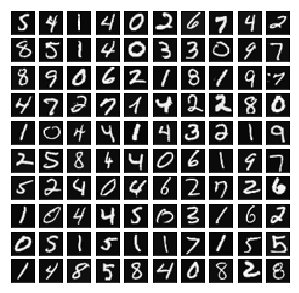

In [3]:
def plot_100_image(X):
    
    num = np.random.randint(1,5000,100)
    image = X[num,:]
    
    fig,ax = plt.subplots(nrows=10,ncols=10,sharey=True,sharex=True,figsize=(5,5))
    
    for i in range(10):
        for j in range(10):
            ax[i,j].matshow(image[10*i+j,1:].reshape(20,20).T,cmap='gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  

plot_100_image(X)
plt.show

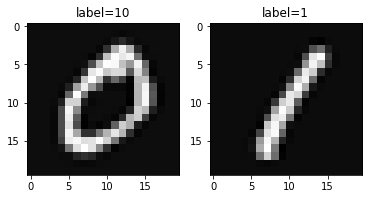

In [4]:
#当label=10时，代表手写数字0
label_10_index = np.where(y==10)[0][0]
label_1_index = np.where(y==1)[0][0]
plt.subplot(121)
plt.imshow(X[label_10_index,1:].reshape(20,20).T,cmap='gray')
plt.title('label=%d'%10)
plt.subplot(122)
plt.imshow(X[label_1_index,1:].reshape(20,20).T,cmap='gray')
plt.title('label=%d'%1)
plt.show()

In [5]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
print(y_onehot.shape)
for i in range(1,11):
    print('label=%d '%i+str(y_onehot[np.where(y==i)[0][0]]))
y = y_onehot

(5000, 10)
label=1 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
label=2 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
label=3 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
label=4 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
label=5 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
label=6 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
label=7 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
label=8 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
label=9 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### 1.2 模型构建及代价函数

In [6]:
weights = loadmat('ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
print(Theta1.shape,Theta2.shape)

(25, 401) (10, 26)


In [7]:
def flattenTheta(ThetaList):
    Thetas = np.concatenate((np.ravel(ThetaList[0]), np.ravel(ThetaList[1])))
    return Thetas.reshape(Thetas.shape[0],1)

def unflattenTheta(Thetas):
    return [Thetas[:25 * 401].reshape(25, 401),Thetas[25 * 401:].reshape(10,26)]

Thetas = flattenTheta([Theta1,Theta2])
print(Thetas.shape)

(10285, 1)


In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def propagateForward(X,Thetas):
    ThetaList = unflattenTheta(Thetas)
    features = X
    za_perlayer = []
    for i in range(len(ThetaList)):
        theta = ThetaList[i]
        z = np.dot(features,theta.T)
        a = sigmoid(z)
        za_perlayer.append((z,a))
        if i == len(ThetaList)-1:
            return za_perlayer
        a = np.insert(a,0,1,axis=1)
        features = a
a = propagateForward(X,Thetas)
print(a[0][0].shape)
print(a[0][1][1].shape)
print(a[1][0].shape)
print(a[1][1].shape)

(5000, 25)
(25,)
(5000, 10)
(5000, 10)


In [11]:
def comupteRegularizedCost(Thetas,X,y,lam=0.):
    m = X.shape[0]
    za_perlayer = propagateForward(X,Thetas)
    yprob = za_perlayer[-1][1]
    cost_term = (1/m)*np.sum(-np.multiply(y,np.log(yprob)) -np.multiply((1-y),np.log(1-yprob)))
    regu_term = (lam / (2 * m))* np.sum([theta*theta for theta in Thetas])
    return cost_term+regu_term

In [12]:
comupteRegularizedCost(Thetas,X,y,0)

0.2876291651613189

 ## 2 反向传播
 ### 2.1 计算梯度

In [13]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

def comupteRegularizedGradient(Thetas,X,y,lam=0.):
    ThetaList = unflattenTheta(Thetas)#(25, 401) (10, 26)
    m = X.shape[0]
    delta1 = np.zeros_like(ThetaList[0])
    delta2 = np.zeros_like(ThetaList[1])
    
    for i in range(m):
        a1 = X[i].reshape(1,X.shape[1])# 1,401
        za_perlayer = propagateForward(a1,Thetas)
        a2 = za_perlayer[0][0]#1,25
        z2 = za_perlayer[0][1]#1,25
        a3 = za_perlayer[1][0]#1,10
        z3 = za_perlayer[1][1]#1,10
        ylabel = y[i].reshape(1,y.shape[1]) # 1,10
        a2 = np.insert(a2,0,1,axis=1)#1,26
        d3 = z3 - ylabel #1,10
        d2 = np.multiply(np.dot(ThetaList[1].T[1:,:],d3.T),sigmoidGradient(z2).T) #25,1
        
        delta1 += np.dot(d2,a1) # 25,401
        delta2 += np.dot(d3.T,a2) #10,26
        
    D1 = delta1/m
    D2 = delta2/m
    
    D1[:,1:] = D1[:,1:] + (float(lam)/m)*ThetaList[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(lam)/m)*ThetaList[1][:,1:]
    
    return flattenTheta([D1, D2])

Thetas = flattenTheta([Theta1,Theta2])
Deltas = comupteRegularizedGradient(Thetas,X,y,lam=0.)
D1,D2 = unflattenTheta(Deltas)
print(Deltas.shape,D1.shape,D2.shape)

(10285, 1) (25, 401) (10, 26)


### 2.2 梯度校验

In [14]:
def checkGradient(X,y,Thetas,Deltas,lam=0.):
    for i in range(10):
        #x = int(np.random.randint(0,Thetas.shape[0],1))
        x = 7396
        eps = np.zeros_like(Thetas)
        eps[x]= 0.0001
        cost_high = comupteRegularizedCost(Thetas+eps,X,y,lam=lam)
        cost_low  = comupteRegularizedCost(Thetas-eps,X,y,lam=lam)
        grad = (cost_high - cost_low) / float(2*0.0001)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,grad,Deltas[x,0]))


### 2.3 训练

In [15]:
def nn_training(X, y):
    init_theta = np.random.uniform(-0.12, 0.12, size=(10285,1))
    lam=0
    res = opt.minimize(fun=comupteRegularizedCost,
                       x0=init_theta,
                       args=(X, y, lam),
                       method='TNC',
                       jac=comupteRegularizedGradient,
                       options={'maxiter': 400})
    return res

In [16]:
res = nn_training(X, y)
res

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


     fun: 1.7965391405513336
     jac: array([[ 0.03947954],
       [ 0.        ],
       [ 0.        ],
       ...,
       [-0.25795047],
       [ 0.02790722],
       [ 0.17758007]])
 message: 'Linear search failed'
    nfev: 155
     nit: 7
  status: 4
 success: False
       x: array([-0.9989396 , -0.09454578, -0.09403482, ..., -1.845673  ,
       -0.36713752,  3.17600163])

### 2.4 测试准确率

In [17]:
final_theta = res.x
y=np.squeeze(data['y'])
def computeAccuracy(X,y,final_theta):
    yprob = propagateForward(X,final_theta)[-1][-1]
    ypred = np.argmax(yprob, axis=1) + 1
    acc = np.mean(ypred == y)
    return acc

## 3 显示隐藏层

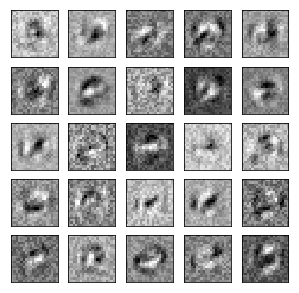

In [18]:
def plot_hidden_layer(Thetas):
    Theta1, _ = unflattenTheta(Thetas)
    hidden_layer = Theta1[:, 1:]  

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap='gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

plot_hidden_layer(final_theta)